### 📦 Importing Libraries
We start by importing all the required Python libraries for data processing and visualization.
We begin by importing Python packages used for data manipulation and visualization.

In [1]:
import sys

import pandas as pd
import numpy as np
import json
import os
import datetime
import tqdm

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch


pd.set_option('display.max_columns', None)

### 📥 Reading Match Metadata & Tracking Data

In [2]:
with open('match_metadata_file.json', 'r') as openfile:
    match_metadata = json.load(openfile)
 

In [3]:
with open('match_tracking_data_file.json', 'r') as openfile:
    match_tracking_data = json.load(openfile)

### ⚙️ Defining Helper Functions
Utility functions are defined to support repeated operations such as data formatting, filtering, or calculations.
These functions prepare and transform match data into a format ready for tactical analysis.

In [4]:

def get_tracking_data_useable(match_metadata,
                              match_tracking_data):
    
    ## Get Player Information 
    home_team_players = pd.DataFrame(match_metadata['HomeTeam']['Players'])
    home_team_players['team_name'] = match_metadata['HomeTeam']['LongName']
    home_team_players['tracab_team_id'] = match_metadata['HomeTeam']['TeamID']
    home_team_players['team'] = 1
    away_team_players = pd.DataFrame(match_metadata['AwayTeam']['Players'])
    away_team_players['team_name'] = match_metadata['AwayTeam']['LongName']
    away_team_players['tracab_team_id'] = match_metadata['AwayTeam']['TeamID']
    away_team_players['team'] = 0 
    starting_frame = home_team_players.loc[home_team_players['StartFrameCount']>0, 
                                           'StartFrameCount'].min()
    home_team_players['starter'] = home_team_players['StartFrameCount'] == starting_frame
    away_team_players['starter'] = away_team_players['StartFrameCount'] == starting_frame
    players = pd.concat([home_team_players, away_team_players])
    
    ## Get Pitch Dimensions and frames
    pitch_length = match_metadata['PitchLongSide']
    pitch_width = match_metadata['PitchShortSide']
    frames = match_tracking_data['FrameData']
    all_frame_dicts = []
    ball_team_to_0_1 = {'H': 1, 'A': 0}
    
    # Parse tracking data frame by frame 
    for f in frames: 
        frame = f['FrameCount']
        running = f['GameRunning']
        period = f['Phase']
        ball_status = f['BallPosition'][0]
        ball_x = ball_status['X']
        ball_y = ball_status['Y']
        ball_z = ball_status['Z']
        ball_speed = ball_status['Speed']
        ball_team = ball_team_to_0_1[ball_status['BallOwningTeam']]
        ball_da = ball_status['BallStatus']
        for pp in f['PlayerPositions']:
            if pp['Team'] in [0,1]:
                player_frame_dict = {'frame': frame,
                                     'running': running,
                                     'period': period,
                                     'ball_x': ball_x,
                                     'ball_y': ball_y, 
                                     'ball_z': ball_z,
                                     'ball_speed': ball_speed,
                                     'ball_team': ball_team,
                                     'ball_da': ball_da}
                player_frame_dict.update(pp)
                all_frame_dicts.append(player_frame_dict)
    tracking_df = pd.DataFrame(all_frame_dicts)
    tracking_df['in_poss'] = tracking_df['Team'] == tracking_df['ball_team']
    
    # Figure out which team is going left to right then create adjusted coordinates
    mean_poss_team = pd.DataFrame(tracking_df.groupby(['period','Team'])['X'].mean())
    min_idx = mean_poss_team.groupby('period')['X'].idxmin()
    l2r_team = mean_poss_team.loc[min_idx]
    l2r_team['l2r'] = True
    l2r_team.reset_index(inplace=True)
    tracking_df = pd.merge(tracking_df, 
                           l2r_team[['period','Team','l2r']], 
                           on = ['period', 'Team'],
                           how = 'left')
    tracking_df['l2r'] = tracking_df['l2r'].fillna(False)
    in_poss_ball = pd.DataFrame(
        tracking_df
        .loc[tracking_df['in_poss']]
        .groupby(['period', 'frame'])
        [['l2r', 'ball_x', 'ball_y']]
        .first()).reset_index()
    
    #These coordinates adjust so that both teams are going left to right 
    # and that the ball is going l2r with the possession team
    in_poss_ball['ball_x_adj'] = np.where(in_poss_ball['l2r'],
                                          (in_poss_ball['ball_x']/100 + pitch_length/200)/
                                          ((pitch_length/10500)*1.05),
                                          (-in_poss_ball['ball_x']/100 + pitch_length/200)/
                                          ((pitch_length/10500)*1.05))
    in_poss_ball['ball_y_adj'] = np.where(in_poss_ball['l2r'],
                                          (in_poss_ball['ball_y']/100 + pitch_length/200)/
                                          ((pitch_length/6800)*0.68),
                                          (-in_poss_ball['ball_y']/100 + pitch_length/200)/
                                          ((pitch_length/6800)*0.68))
    tracking_df = pd.merge(tracking_df, 
                           in_poss_ball[['period', 'frame', 'ball_x_adj']], 
                           on = ['period', 'frame'], 
                           how='left')
    tracking_df['x_adj'] = np.where(tracking_df['l2r'], 
                                    (tracking_df['X']/100 + pitch_length/200)/
                                    ((pitch_length/10500)*1.05),
                                    (-tracking_df['X']/100 + pitch_length/200)/
                                    ((pitch_length/10500)*1.05))
    tracking_df['y_adj'] = np.where(tracking_df['l2r'], 
                                    (tracking_df['Y']/100 + pitch_width/200)/
                                    ((pitch_width/6800)*0.68),
                                    (-tracking_df['Y']/100 + pitch_width/200)/
                                    ((pitch_width/6800)*0.68))
    tracking_df = pd.merge(tracking_df, 
                           players, 
                           left_on = ['Team', 'JerseyNumber'],
                           right_on = ['team', 'JerseyNo'])
    tracking_df.sort_values(['period', 'frame'], inplace=True)
    
    ## Dead frames (typically a good sense of when a set piece is coming)
    tracking_df['dead_frame'] = np.where(tracking_df['ball_da']=='Dead',
                                         tracking_df['frame'],
                                         np.nan)
    tracking_df['last_dead_frame'] = tracking_df['dead_frame'].ffill()
    tracking_df['frames_since_last_dead'] = tracking_df['frame'] - tracking_df['last_dead_frame']
    return tracking_df

In [5]:
tracking_df = get_tracking_data_useable(match_metadata,match_tracking_data)## Read In Tracking Data and Metadata

### 🛡️ Defensive Line Height
We evaluate how far up the pitch the defensive line is positioned.

### 📊 Visualizing Tactical Insights

In [6]:
def calculate_avg_def_line(tracking_df, team, ball_da, in_poss):
    # Filter for players in the specified team with CurrentPosition as 'D' (Centerbacks)
    centerbacks = tracking_df.loc[(tracking_df['CurrentPosition'] == 'D') & 
                                  (tracking_df['team_name'] == team)]
    
    # Extract unique JerseyNumbers of the centerbacks
    unique_jersey_numbers = centerbacks['JerseyNumber'].unique()

    for JerseyNumber in unique_jersey_numbers:
        # Get player's first name and last name
        player_data = centerbacks.loc[(centerbacks['JerseyNumber'] == JerseyNumber) & 
                                      (centerbacks['ball_da'] == ball_da)]
        
        if player_data.empty:
            print(f"No data found for player with Jersey Number: {JerseyNumber}")
            continue
        
        player_name = f"{player_data.iloc[0]['FirstName']} {player_data.iloc[0]['LastName']}"

        # Get data for the specified player with conditions for ball_da and in_poss
        tracking_player = player_data.loc[(player_data['in_poss'] == in_poss)]
        
        x_adj_values = tracking_player['x_adj'].tolist()
        y_adj_values = tracking_player['y_adj'].tolist()

        # Calculate average
        if x_adj_values and y_adj_values: 
            x_adj_avg = sum(x_adj_values) / len(x_adj_values)
            y_adj_avg = sum(y_adj_values) / len(y_adj_values)
        else:
            x_adj_avg = 0
            y_adj_avg = 0

        print(f"The average x_adj for {player_name} when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {x_adj_avg}")
        print(f"The average y_adj for {player_name} when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {y_adj_avg}\n")



#TODO:
#make this in different subsets and plot them using mplsoccer
# visuals, get lines for inter miami, and other team. (different attacking thirds, when they have the ball where is our defensive line,
# when we have the ball where is their defensive line) And compare them, then to league aerage


In [7]:
calculate_avg_def_line(tracking_df, 'Inter Miami CF', 'Alive', True)

The average x_adj for Tomás Avilés when ball_da is Alive and possession is True, is 33.223704928174946
The average y_adj for Tomás Avilés when ball_da is Alive and possession is True, is 27.68356840662089

The average x_adj for Kamal Miller when ball_da is Alive and possession is True, is 31.149472575063246
The average y_adj for Kamal Miller when ball_da is Alive and possession is True, is 68.80959799231577

The average x_adj for Sergii Kryvtsov when ball_da is Alive and possession is True, is 29.50930108462401
The average y_adj for Sergii Kryvtsov when ball_da is Alive and possession is True, is 45.89067356293478

The average x_adj for DeAndre Yedlin when ball_da is Alive and possession is True, is 49.39725769966873
The average y_adj for DeAndre Yedlin when ball_da is Alive and possession is True, is 17.17912878721007

The average x_adj for Noah Allen when ball_da is Alive and possession is True, is 45.93712342079697
The average y_adj for Noah Allen when ball_da is Alive and possessio

### 📊 Visualizing Tactical Insights

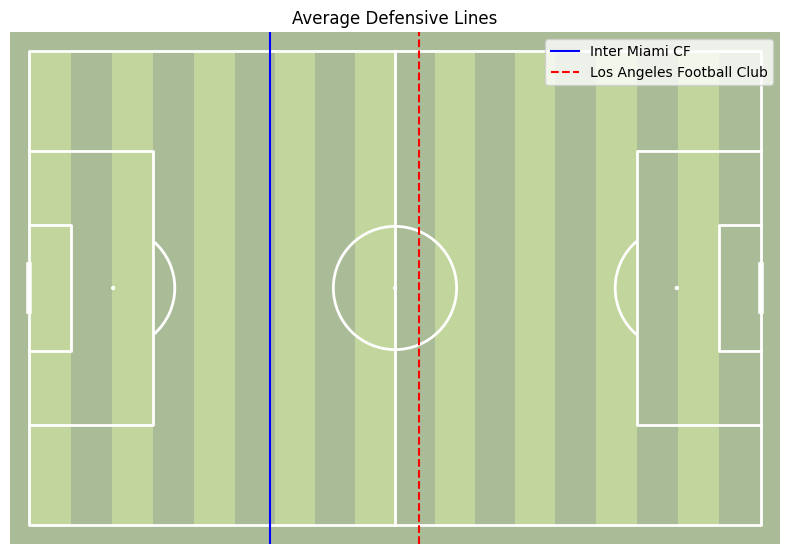

In [8]:


def plot_defensive_lines(tracking_df):
    # Initialize the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(8, 6))
    
    # Calculate average defensive line for Inter Miami CF
    inter_miami_df = tracking_df.loc[(tracking_df['team_name'] == 'Inter Miami CF') & 
                                     (tracking_df['CurrentPosition'] == 'D')]
    inter_miami_x_avg = inter_miami_df['x_adj'].mean()
    
    # Plot the line for Inter Miami CF
    ax.axvline(x=inter_miami_x_avg, color='blue', label='Inter Miami CF', linestyle='-')
    
    # Calculate average defensive line for the other team
    other_team_name = tracking_df.loc[(tracking_df['team_name'] != 'Inter Miami CF')]['team_name'].unique()[0]
    other_team_df = tracking_df.loc[(tracking_df['team_name'] == other_team_name) & 
                                    (tracking_df['CurrentPosition'] == 'D')]
    other_team_x_avg = other_team_df['x_adj'].mean()
    
    # Plot the line for the other team
    ax.axvline(x=100-other_team_x_avg, color='red', label=other_team_name, linestyle='--')
    
    plt.title("Average Defensive Lines")
    plt.legend()
    plt.show()

# Example usage:
plot_defensive_lines(tracking_df)


# Usage:
# plot_avg_defensive_line(tracking_df, 'Inter Miami CF', 'Opponent Team', 'Alive')


### 🛡️ Defensive Line Height
We evaluate how far up the pitch the defensive line is positioned.

In [9]:
def plot_both_teams(tracking_df, team_name_1, team_name_2, ball_x_adj_max, ball_x_adj_min):
    # Extract team names from the tracking data
    unique_teams = tracking_df['team_name'].unique()
    if team_name_1 not in unique_teams or team_name_2 not in unique_teams:
        print("One or both team names provided are not in the dataset!")
        return

    def compute_avg_positions(df, team_name, in_poss):
        team_df = df.loc[(df['team_name'] == team_name) & 
                         (df['ball_da'] == 'Alive') &
                         (df['ball_x_adj'] < ball_x_adj_max) &
                         (df['ball_x_adj'] >= ball_x_adj_min) &
                         (df['in_poss'] == in_poss) &
                         (df['StartingPosition'] != 'G') &
                         (df['starter'] == True)]
        
        # Group by PlayerID and compute average positions
        avg_positions = team_df.groupby('PlayerID').agg(
            LastName=('LastName', 'first'),
            JerseyNumber=('JerseyNumber', 'first'),
            x_adj=('x_adj', 'mean'),
            y_adj=('y_adj', 'mean')
        ).reset_index()
        return avg_positions.head(11)

    team_1_positions = compute_avg_positions(tracking_df, team_name_1, False)
    team_2_positions = compute_avg_positions(tracking_df, team_name_2, True)
    team_2_positions['x_adj'] = 100 - team_2_positions['x_adj']
    team_2_positions['y_adj'] = 100 - team_2_positions['y_adj']
    

    # Initialize the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Plot team 1
    if len(team_1_positions) >= 3:
        hull = pitch.convexhull(team_1_positions['x_adj'].tolist(), team_1_positions['y_adj'].tolist())
        pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
    pitch.scatter(team_1_positions['x_adj'].tolist(), team_1_positions['y_adj'].tolist(), ax=ax, edgecolor='black', facecolor='cornflowerblue', s=200)

    # Plot team 2
    if len(team_2_positions) >= 3:
        hull = pitch.convexhull(team_2_positions['x_adj'].tolist(), team_2_positions['y_adj'].tolist())
        pitch.polygon(hull, ax=ax, edgecolor='orange', facecolor='orange', alpha=0.3)
    pitch.scatter(team_2_positions['x_adj'].tolist(), team_2_positions['y_adj'].tolist(), ax=ax, edgecolor='black', facecolor='orange', s=200)

    # Annotate the pitch with player names and jersey numbers
    for team_positions, color in zip([team_1_positions, team_2_positions], ['black', 'black']):
        for _, player in team_positions.iterrows():
            ax.text(player['x_adj'], player['y_adj'], f"{player['JerseyNumber']}", fontsize=8, ha='center', va='center', color=color)
            ax.text(player['x_adj'], player['y_adj'] + 2, player['LastName'], fontsize=9, ha='center', va='bottom', color=color)
            
    # Add annotations for attacking and defending teams
    ax.text(5, 95, f"{team_name_1} (Defending)", fontsize=10, ha='left', va='center', color='cornflowerblue', bbox=dict(facecolor='white', edgecolor='cornflowerblue', boxstyle='round,pad=0.5'))
    ax.text(95, 5, f"{team_name_2} (Attacking)", fontsize=10, ha='right', va='center', color='orange', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

    
    if ball_x_adj_max == 66.7 and ball_x_adj_min == 33.3:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Middle Third")
    elif ball_x_adj_max == 100 and ball_x_adj_min == 66.7:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Attacking Third")
    elif ball_x_adj_max == 33.3 and ball_x_adj_min == 0:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Defensive Third")
  

    plt.show()

## Attacking Third

### ⚙️ Defining Helper Functions
Utility functions are defined to support repeated operations such as data formatting, filtering, or calculations.
These functions prepare and transform match data into a format ready for tactical analysis.

In [10]:
def calculate_avg_def_line_att_third(tracking_df, jersey_numbers, team, ball_da, in_poss):
    for JerseyNumber in jersey_numbers:
        # Get player's first name and last name
        player_data = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                      (tracking_df['Team'] == team) & 
                                      (tracking_df['ball_da'] == ball_da)]
        
        if player_data.empty:
            print(f"No data found for player with Jersey Number: {JerseyNumber}")
            continue
        
        player_name = f"{player_data.iloc[0]['FirstName']} {player_data.iloc[0]['LastName']}"

        # Get data for the specified player
        tracking_player = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                          (tracking_df['Team'] == team) & 
                                          (tracking_df['ball_da'] == ball_da) & 
                                          (tracking_df['in_poss'] == in_poss)&
                                          (tracking_df['ball_x_adj']>66.7)]
        
        x_adj_values = []
        y_adj_values = []

        # Loop through each row of ball_da from dataframe
        for index, row in tracking_player.iterrows():
            x_adj_values.append(row['x_adj'])
            y_adj_values.append(row['y_adj'])

        # Calculate average
        if x_adj_values and y_adj_values:  # This checks if the lists are not empty
            x_adj_avg = sum(x_adj_values) / len(x_adj_values)
            y_adj_avg = sum(y_adj_values) / len(y_adj_values)
        else:
            x_adj_avg = 0
            y_adj_avg = 0

        print(f"The average x_adj for {player_name} in the attacking third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {x_adj_avg}")
        print(f"The average y_adj for {player_name} in the attacking third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {y_adj_avg}\n")

# Usage example:
# calculate_avg_def_line_att_third(tracking_df, [6, 27, 31], 0, 'Alive', True)

In [11]:
calculate_avg_def_line_att_third(tracking_df, [6, 27, 31], 0, 'Alive', True)

The average x_adj for Tomás Avilés in the attacking third when ball_da is Alive and possession is True, is 53.36462864757562
The average y_adj for Tomás Avilés in the attacking third when ball_da is Alive and possession is True, is 30.842797904302937

The average x_adj for Sergii Kryvtsov in the attacking third when ball_da is Alive and possession is True, is 50.94266459982039
The average y_adj for Sergii Kryvtsov in the attacking third when ball_da is Alive and possession is True, is 49.39923687499488

The average x_adj for Kamal Miller in the attacking third when ball_da is Alive and possession is True, is 52.19117456691427
The average y_adj for Kamal Miller in the attacking third when ball_da is Alive and possession is True, is 68.33999619265191



## Middle Third

### ⚙️ Defining Helper Functions
Utility functions are defined to support repeated operations such as data formatting, filtering, or calculations.
These functions prepare and transform match data into a format ready for tactical analysis.

In [12]:
def calculate_avg_def_line_mid_third(tracking_df, jersey_numbers, team, ball_da, in_poss):
    for JerseyNumber in jersey_numbers:
        # Get player's first name and last name
        player_data = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                      (tracking_df['Team'] == team) & 
                                      (tracking_df['ball_da'] == ball_da)]
        
        if player_data.empty:
            print(f"No data found for player with Jersey Number: {JerseyNumber}")
            continue
        
        player_name = f"{player_data.iloc[0]['FirstName']} {player_data.iloc[0]['LastName']}"

        # Get data for the specified player
        tracking_player = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                          (tracking_df['Team'] == team) & 
                                          (tracking_df['ball_da'] == ball_da) & 
                                          (tracking_df['in_poss'] == in_poss)&
                                          (tracking_df['ball_x_adj']<66.7)&
                                          (tracking_df['ball_x_adj']>33.3)]
        
        x_adj_values = []
        y_adj_values = []

        # Loop through each row of ball_da from dataframe
        for index, row in tracking_player.iterrows():
            x_adj_values.append(row['x_adj'])
            y_adj_values.append(row['y_adj'])

        # Calculate average
        if x_adj_values and y_adj_values:  # This checks if the lists are not empty
            x_adj_avg = sum(x_adj_values) / len(x_adj_values)
            y_adj_avg = sum(y_adj_values) / len(y_adj_values)
        else:
            x_adj_avg = 0
            y_adj_avg = 0

        print(f"The average x_adj for {player_name} in the middle third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {x_adj_avg}")
        print(f"The average y_adj for {player_name} in the middle third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {y_adj_avg}\n")

# Usage example:
# calculate_avg_def_line_mid_third(tracking_df, [6, 27, 31], 0, 'Alive', True)




In [13]:
calculate_avg_def_line_mid_third(tracking_df, [6, 27, 31], 0, 'Alive', True)

The average x_adj for Tomás Avilés in the middle third when ball_da is Alive and possession is True, is 37.78127398376018
The average y_adj for Tomás Avilés in the middle third when ball_da is Alive and possession is True, is 27.24577752562618

The average x_adj for Sergii Kryvtsov in the middle third when ball_da is Alive and possession is True, is 33.884165050255774
The average y_adj for Sergii Kryvtsov in the middle third when ball_da is Alive and possession is True, is 46.78906411720993

The average x_adj for Kamal Miller in the middle third when ball_da is Alive and possession is True, is 36.12492841608517
The average y_adj for Kamal Miller in the middle third when ball_da is Alive and possession is True, is 71.10526796644004



## Defensive Third

### 🛡️ Analyzing Defensive Lines
Calculates and visualizes team defensive lines, providing insights into team structure and coordination.

In [14]:
def calculate_avg_def_line_def_third(tracking_df, jersey_numbers, team, ball_da, in_poss):
    for JerseyNumber in jersey_numbers:
        # Get player's first name and last name
        player_data = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                      (tracking_df['Team'] == team) & 
                                      (tracking_df['ball_da'] == ball_da)]
        
        if player_data.empty:
            print(f"No data found for player with Jersey Number: {JerseyNumber}")
            continue
        
        player_name = f"{player_data.iloc[0]['FirstName']} {player_data.iloc[0]['LastName']}"

        # Get data for the specified player
        tracking_player = tracking_df.loc[(tracking_df['JerseyNumber'] == JerseyNumber) & 
                                          (tracking_df['Team'] == team) & 
                                          (tracking_df['ball_da'] == ball_da) & 
                                          (tracking_df['in_poss'] == in_poss)&
                                          (tracking_df['ball_x_adj']<33.3)]
        
        x_adj_values = []
        y_adj_values = []

        # Loop through each row of ball_da from dataframe
        for index, row in tracking_player.iterrows():
            x_adj_values.append(row['x_adj'])
            y_adj_values.append(row['y_adj'])

        # Calculate average
        if x_adj_values and y_adj_values:  # This checks if the lists are not empty
            x_adj_avg = sum(x_adj_values) / len(x_adj_values)
            y_adj_avg = sum(y_adj_values) / len(y_adj_values)
        else:
            x_adj_avg = 0
            y_adj_avg = 0

        print(f"The average x_adj for {player_name} in the defensive third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {x_adj_avg}")
        print(f"The average y_adj for {player_name} in the defensive third when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'}, is {y_adj_avg}\n")

# Usage example:
# calculate_avg_def_line_def_third(tracking_df, [6, 27, 31], 0, 'Alive', True)




In [15]:
calculate_avg_def_line_def_third(tracking_df, [6, 27, 31], 0, 'Alive', True)

The average x_adj for Tomás Avilés in the defensive third when ball_da is Alive and possession is True, is 17.52774602462047
The average y_adj for Tomás Avilés in the defensive third when ball_da is Alive and possession is True, is 26.688775414772948

The average x_adj for Sergii Kryvtsov in the defensive third when ball_da is Alive and possession is True, is 13.410961385844804
The average y_adj for Sergii Kryvtsov in the defensive third when ball_da is Alive and possession is True, is 43.023462793040984

The average x_adj for Kamal Miller in the defensive third when ball_da is Alive and possession is True, is 14.479064560002936
The average y_adj for Kamal Miller in the defensive third when ball_da is Alive and possession is True, is 66.11818819842101



In [ ]:
plot_combined_defensive_lines(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 'Alive',66.7, 33.3)

#  How high is the defensive line (far away from the goal line) 

In [25]:
def calculate_team_def_avg(tracking_df, defending_team, ball_da, in_poss, ball_x_adj_max, ball_x_adj_min):
    filtered_data = tracking_df.loc[(tracking_df['team_name'] == defending_team) & 
                                    (tracking_df['ball_da'] == ball_da) & 
                                    (tracking_df['in_poss'] == in_poss) &
                                    (tracking_df['ball_x_adj'] < ball_x_adj_max)  &
                                    (tracking_df['ball_x_adj'] >= ball_x_adj_min) & 
                                    (tracking_df['CurrentPosition'] == 'D')].copy()

    # Identify frames where ball is dead
    filtered_data['ball_dead'] = filtered_data['ball_da'] == 'dead'

    # Identify frames within 5 seconds after the ball goes dead
    filtered_data['post_dead'] = filtered_data['ball_dead'].rolling(min_periods=1, window=125).sum() > 0

    # Now filter out these 'post_dead' frames
    filtered_data = filtered_data[~filtered_data['post_dead']]

    if filtered_data.empty:
        return 0

    # Get the list of minimum x_adj values across all defenders
    min_x_adj_values = filtered_data.groupby('frame')['x_adj'].min().tolist()
    

    # Calculate the average of these minimum values
    return sum(min_x_adj_values) / len(min_x_adj_values) if min_x_adj_values else 0


In [26]:
def plot_combined_defensive_lines(tracking_df, team_A, team_B, ball_da, ball_x_adj_max, ball_x_adj_min):
    # Calculate the average defensive line for both teams
    team_A_def_avg = calculate_team_def_avg(tracking_df, team_A, ball_da, False, ball_x_adj_max, ball_x_adj_min)
    team_B_def_avg = calculate_team_def_avg(tracking_df, team_B, ball_da, False, ball_x_adj_max, ball_x_adj_min)
    
    # Initialize the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(10, 6))
    
    # Plot the defensive line for Team A on the left half
    ax.axvline(x=team_A_def_avg, color='blue', label=f"{team_A} Defending", linestyle='-')
    
    # Plot the defensive line for Team B on the right half
    ax.axvline(x=team_B_def_avg, color='red', label=f"{team_B} Defending", linestyle='--')
    
    if ball_x_adj_max == 66.7 and ball_x_adj_min == 33.3:
        plt.title(f"Defensive Lines of {team_A} and {team_B} in the Middle Third")
        plt.legend(loc='upper right')
    elif ball_x_adj_max == 100 and ball_x_adj_min == 66.7:
        plt.title(f"Defensive Lines of {team_A} and {team_B} in the Attacking Third")
        plt.legend(loc='upper right')
    elif ball_x_adj_max == 33.3 and ball_x_adj_min == 0:
        plt.title(f"Defensive Lines of {team_A} and {team_B} in the Defensive Third")
        plt.legend(loc='upper right')

        
    

    
    plt.show()

# Example usage:
# plot_combined_defensive_lines(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 'Alive', 66.7, 33.3)

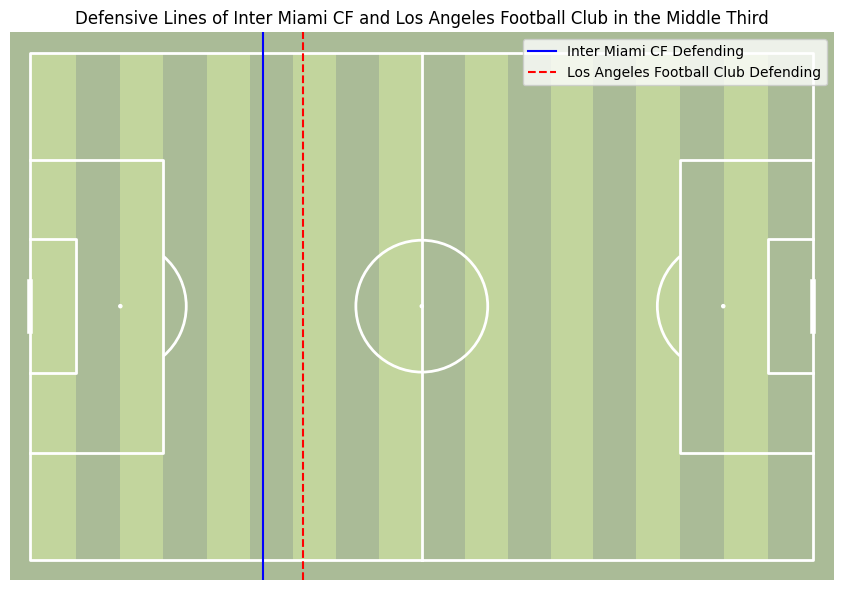

In [28]:
plot_combined_defensive_lines(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 'Alive',66.7, 33.3)

# How compact is the defensive team's shape (look at convex hulls for this)

### 📐 Convex Hull Creation
Here, convex hulls are used to visualize team shapes during different phases of play. This is crucial for spatial analysis in soccer tactics.

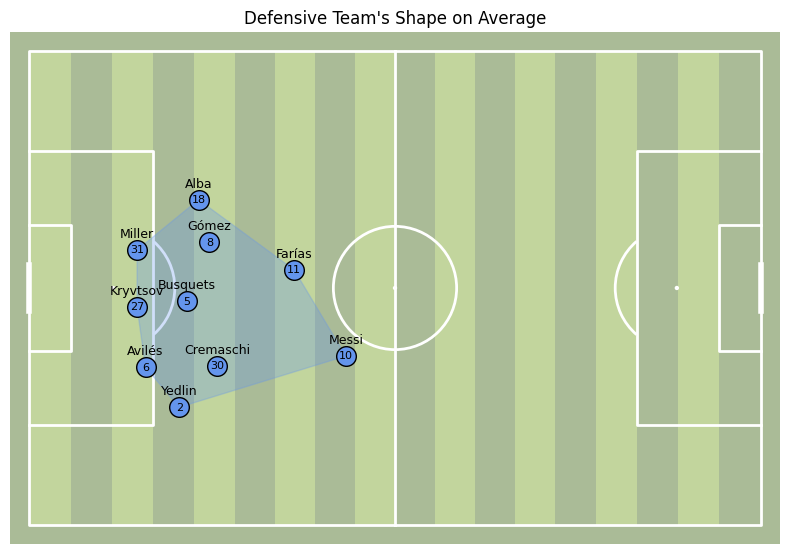

In [16]:
# Filter the DataFrame for Inter Miami CF players who were starters, where ball_da is 'Alive', and excluding the goalkeeper
inter_miami_df = tracking_df.loc[(tracking_df['team_name'] == 'Inter Miami CF') & 
                                 (tracking_df['ball_da'] == 'Alive') &
                                 (tracking_df['starter'] == True) & 
                                 (tracking_df['ball_x_adj'] > 66.7) &
                                 (tracking_df['in_poss'] == False) &
                                 (tracking_df['StartingPosition'] != 'G')]

# Group by PlayerID and get the first names, last names, jersey numbers, and calculate the mean for x_adj and y_adj
player_avg_positions = inter_miami_df.groupby('PlayerID').agg(
    LastName=('LastName', 'first'),
    JerseyNumber=('JerseyNumber', 'first'),
    x_adj=('x_adj', 'mean'),
    y_adj=('y_adj', 'mean')
).reset_index()

# Get the average positions for the first 11 unique players (not including the goalkeeper)
first_eleven_avg_positions = player_avg_positions.head(11)

# Get the x_adj and y_adj data as lists
x_adj_data = first_eleven_avg_positions['x_adj'].tolist()
y_adj_data = first_eleven_avg_positions['y_adj'].tolist()

# Initialize the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white',
              stripe_color='#c2d59d', stripe=True)

# Draw the pitch
fig, ax = pitch.draw(figsize=(8, 6))

# Calculate and plot the convex hull
if len(x_adj_data) >= 3:
    hull = pitch.convexhull(x_adj_data, y_adj_data)
    poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)

# Plot the points as a scatter plot with bigger points
scatter = pitch.scatter(x_adj_data, y_adj_data, ax=ax, edgecolor='black', facecolor='cornflowerblue', s=200)


plt.title("Defensive Team's Shape on Average")

# Offset to raise the text slightly above the point
offset = 2

for i, player in first_eleven_avg_positions.iterrows():
    # Display the jersey number inside the point
    ax.text(player['x_adj'], player['y_adj'], f"{player['JerseyNumber']}", 
            fontsize=8, ha='center', va='center', color='black')
    # Display the player's last name just above the point
    ax.text(player['x_adj'], player['y_adj'] + offset, player['LastName'], 
            fontsize=9, ha='center', va='bottom', color='black')

plt.show()

#TODO
#Make this code as a function


### ⚙️ Defining Helper Functions
Utility functions are defined to support repeated operations such as data formatting, filtering, or calculations.
These functions prepare and transform match data into a format ready for tactical analysis.

In [17]:
def calculate_team_def_avg(tracking_df, team, ball_da, in_poss):
    # Filter data for the specified conditions
    filtered_data = tracking_df.loc[(tracking_df['team_name'] == team) & 
                                    (tracking_df['ball_da'] == ball_da) & 
                                    (tracking_df['in_poss'] == in_poss) &
                                    (tracking_df['CurrentPosition'] == 'D')]
    
    # If no data is present, simply return 
    if filtered_data.empty:
        print(f"No data found for team {team} with specified conditions.")
        return
    
    # Get the list of minimum x_adj values across all defenders
    min_x_adj_values = filtered_data.groupby('frame')['x_adj'].min().tolist()
    
    # Calculate the average of these minimum values
    avg_min_x_adj = sum(min_x_adj_values) / len(min_x_adj_values) if min_x_adj_values else 0

    print(f"The average of the minimum x_adj values for all centerbacks of team {team} when ball_da is {ball_da} and possession is {'True' if in_poss else 'False'} is: {avg_min_x_adj}")

# Usage example:
# calculate_team_def_avg(tracking_df, 'YourTeamName', 'Alive', False)




In [18]:
calculate_team_def_avg(tracking_df, 'Inter Miami CF', 'Alive', False)

The average of the minimum x_adj values for all centerbacks of team Inter Miami CF when ball_da is Alive and possession is False is: 27.493063468617375


### ⚙️ Defining Helper Functions
Utility functions are defined to support repeated operations such as data formatting, filtering, or calculations.
These functions prepare and transform match data into a format ready for tactical analysis.

In [19]:
def calculate_team_def_avg(tracking_df, defending_team, ball_da, in_poss):
    filtered_data = tracking_df.loc[(tracking_df['team_name'] == defending_team) & 
                                    (tracking_df['ball_da'] == ball_da) & 
                                    (tracking_df['in_poss'] == in_poss) &
                                    (tracking_df['CurrentPosition'] == 'D')]
    
    if filtered_data.empty:
        return 0
    
    # Get the list of minimum x_adj values across all defenders
    min_x_adj_values = filtered_data.groupby('frame')['x_adj'].min().tolist()
    
    # Calculate the average of these minimum values
    return sum(min_x_adj_values) / len(min_x_adj_values) if min_x_adj_values else 0





### 📊 Visualizing Tactical Insights

In [20]:
def plot_combined_defensive_lines(tracking_df, team_A, team_B, ball_da):
    # Calculate the average defensive line for both teams
    team_A_def_avg = calculate_team_def_avg(tracking_df, team_A, ball_da, False)
    team_B_def_avg = calculate_team_def_avg(tracking_df, team_B, ball_da, False)
    
    # Initialize the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(10, 6))
    
    # Plot the defensive line for Team A on the left half
    ax.axvline(x=team_A_def_avg, color='blue', label=f"{team_A} Defending", linestyle='-')
    
    # Plot the defensive line for Team B on the right half
    ax.axvline(x=100 - team_B_def_avg, color='red', label=f"{team_B} Defending", linestyle='--')
    
    # Add title and legend
    plt.title(f"Defensive Lines of {team_A} and {team_B}")
    plt.legend(loc='upper right')
    
    plt.show()

# Example usage:
# plot_combined_defensive_lines(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 'Alive')


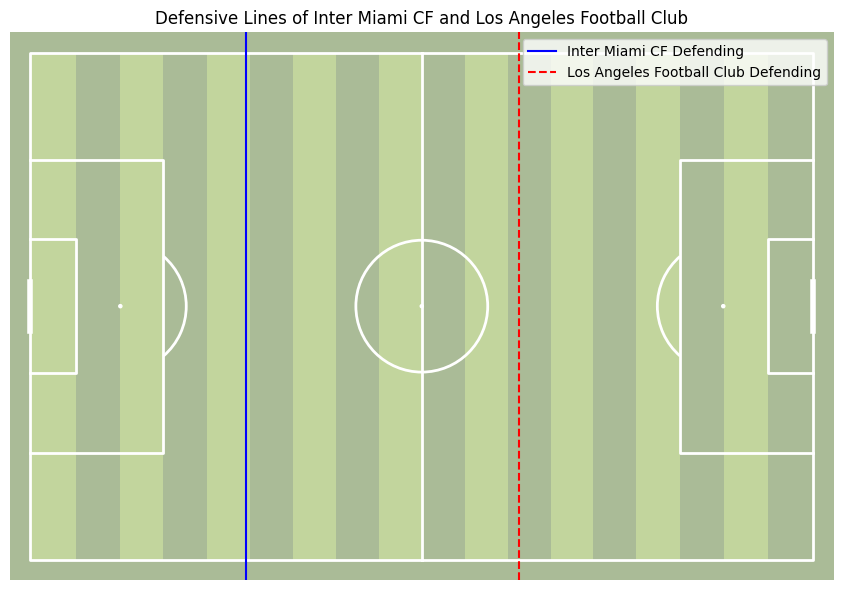

In [21]:
plot_combined_defensive_lines(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 'Alive')

### ⚽ Average Positions of Both Teams
The following function `plot_both_teams()` compares the average positions of two teams' starting outfield players. It filters by possession, adjusted ball position (`ball_x_adj`), and flips the attacking team's view to face the opponent. This helps visualize team shapes and spacing during live match phases.

In [22]:
def plot_both_teams(tracking_df, team_name_1, team_name_2, ball_x_adj_max, ball_x_adj_min):
    # Extract team names from the tracking data
    unique_teams = tracking_df['team_name'].unique()
    if team_name_1 not in unique_teams or team_name_2 not in unique_teams:
        print("One or both team names provided are not in the dataset!")
        return

    def compute_avg_positions(df, team_name, in_poss):
        team_df = df.loc[(df['team_name'] == team_name) & 
                         (df['ball_da'] == 'Alive') &
                         (df['ball_x_adj'] < ball_x_adj_max) &
                         (df['ball_x_adj'] >= ball_x_adj_min) &
                         (df['in_poss'] == in_poss) &
                         (df['StartingPosition'] != 'G') &
                         (df['starter'] == True)]
        
        # Group by PlayerID and compute average positions
        avg_positions = team_df.groupby('PlayerID').agg(
            LastName=('LastName', 'first'),
            JerseyNumber=('JerseyNumber', 'first'),
            x_adj=('x_adj', 'mean'),
            y_adj=('y_adj', 'mean')
        ).reset_index()
        return avg_positions.head(11)

    team_1_positions = compute_avg_positions(tracking_df, team_name_1, False)
    team_2_positions = compute_avg_positions(tracking_df, team_name_2, True)
    team_2_positions['x_adj'] = 100 - team_2_positions['x_adj']
    team_2_positions['y_adj'] = 100 - team_2_positions['y_adj']
    

    # Initialize the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Plot team 1
    if len(team_1_positions) >= 3:
        hull = pitch.convexhull(team_1_positions['x_adj'].tolist(), team_1_positions['y_adj'].tolist())
        pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
    pitch.scatter(team_1_positions['x_adj'].tolist(), team_1_positions['y_adj'].tolist(), ax=ax, edgecolor='black', facecolor='cornflowerblue', s=200)

    # Plot team 2
    if len(team_2_positions) >= 3:
        hull = pitch.convexhull(team_2_positions['x_adj'].tolist(), team_2_positions['y_adj'].tolist())
        pitch.polygon(hull, ax=ax, edgecolor='orange', facecolor='orange', alpha=0.3)
    pitch.scatter(team_2_positions['x_adj'].tolist(), team_2_positions['y_adj'].tolist(), ax=ax, edgecolor='black', facecolor='orange', s=200)

    # Annotate the pitch with player names and jersey numbers
    for team_positions, color in zip([team_1_positions, team_2_positions], ['black', 'black']):
        for _, player in team_positions.iterrows():
            ax.text(player['x_adj'], player['y_adj'], f"{player['JerseyNumber']}", fontsize=8, ha='center', va='center', color=color)
            ax.text(player['x_adj'], player['y_adj'] + 2, player['LastName'], fontsize=9, ha='center', va='bottom', color=color)
            
    # Add annotations for attacking and defending teams
    ax.text(5, 95, f"{team_name_1} (Defending)", fontsize=10, ha='left', va='center', color='cornflowerblue', bbox=dict(facecolor='white', edgecolor='cornflowerblue', boxstyle='round,pad=0.5'))
    ax.text(95, 5, f"{team_name_2} (Attacking)", fontsize=10, ha='right', va='center', color='orange', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

    
    if ball_x_adj_max == 66.7 and ball_x_adj_min == 33.3:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Middle Third")
    elif ball_x_adj_max == 100 and ball_x_adj_min == 66.7:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Attacking Third")
    elif ball_x_adj_max == 33.3 and ball_x_adj_min == 0:
        plt.title(f"Shape on Average of {team_name_1} and {team_name_2} in the Defensive Third")
  

    plt.show()


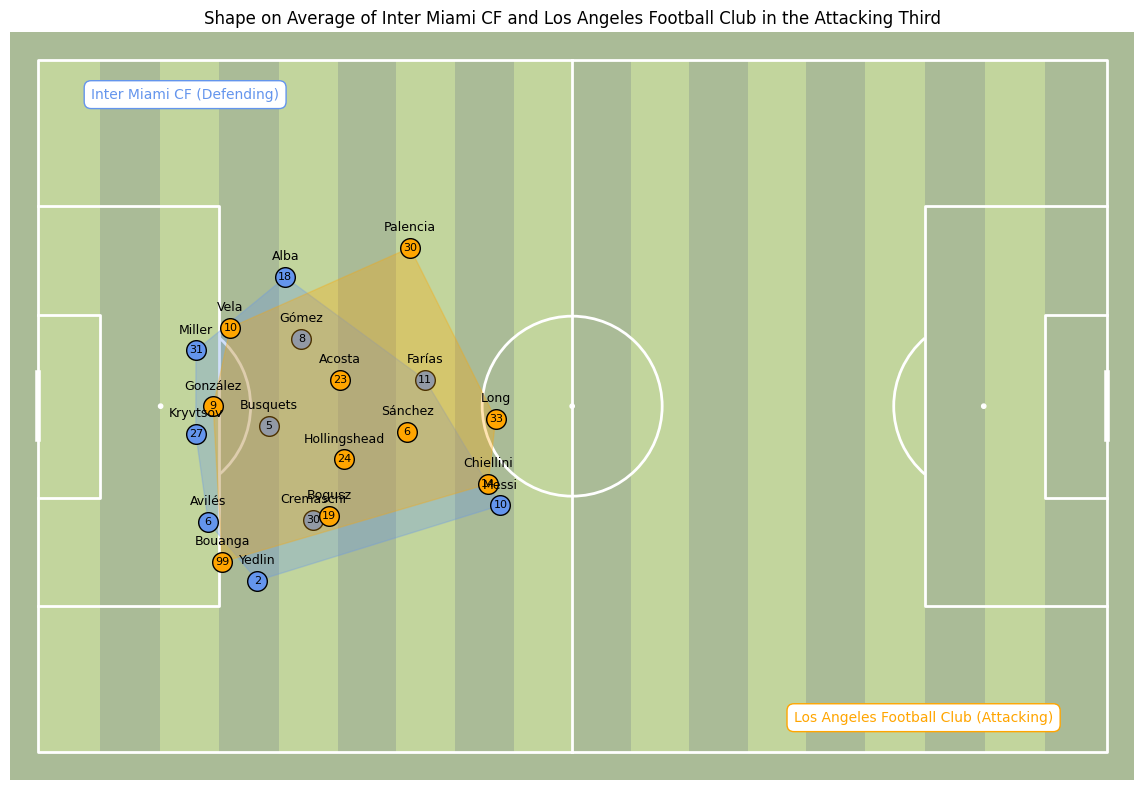

In [23]:
plot_both_teams(tracking_df, 'Inter Miami CF', 'Los Angeles Football Club', 100, 66.7)